## multi-modal, multi-label vit and cnn survival model 5-fold-CV result analysis

In [125]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import lifelines

from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [126]:
# CNN
data = pd.DataFrame()

for i in range(1,1+5):
    temp = pd.read_csv('Predictions_ViT{}.csv'.format(i))
    data = pd.concat([data, temp], ignore_index=True)
    
data = data.drop([data.columns[0]], axis=1)
data

,ID,OS_risk,OS,Death,LFFS_risk,LFFS,LF,RFFS_risk,RFFS,RF,DFFS_risk,DFFS,DF
0,OPC-00002,5.585012,3472,0,2.678481,3472,0,2.324451,3472,0,2.934763,3472,0
1,OPC-00008,12.743567,192,1,4.750291,39,1,3.898618,192,0,5.619485,189,1
2,OPC-00012,1.793600,3516,0,0.953789,3516,0,0.896477,3516,0,1.132652,3516,0
3,OPC-00016,4.623035,3736,0,1.866553,3736,0,1.716059,3736,0,3.018507,3736,0
4,OPC-00017,2.179234,3911,0,1.212103,3911,0,1.178810,3911,0,1.388081,3911,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,OPC-00590,2.750700,3133,0,1.324161,3133,0,1.275567,3133,0,1.762865,3133,0
508,OPC-00596,1.109411,4339,0,0.576797,4339,0,0.537476,4339,0,0.515381,4339,0
509,OPC-00599,10.414908,2126,0,3.908460,2126,0,2.722989,2126,0,3.723275,2126,0
510,OPC-00602,8.155293,71,1,2.705130,71,0,2.215257,71,0,3.032011,71,0


In [127]:
data['OS_risk'].values

array([ 5.585012  , 12.743567  ,  1.7935996 ,  4.6230345 ,  2.1792336 ,
        3.4671268 , 13.238201  ,  5.5463934 ,  9.148571  ,  1.1202613 ,
        1.9997013 ,  2.7499447 , 11.431296  ,  8.536146  ,  6.3355923 ,
       15.288992  ,  2.3513923 ,  1.8286889 ,  5.0647826 ,  1.664608  ,
        2.5928714 , 18.31638   ,  3.3725004 ,  3.1881661 , 25.949062  ,
        4.405351  ,  2.2679424 , 11.72983   ,  1.6099126 ,  3.455594  ,
       10.47951   ,  1.9270405 ,  7.6661305 ,  3.994117  ,  1.3443978 ,
        7.8958673 ,  0.98967427,  9.40896   , 32.800243  ,  1.8990526 ,
       28.571663  , 16.640404  ,  3.473014  ,  8.7465515 , 11.686279  ,
        5.315195  ,  5.898943  ,  6.147572  ,  4.825378  ,  3.661874  ,
        3.3824682 ,  2.5816517 ,  1.5054328 ,  1.548463  , 12.751966  ,
        1.7397944 ,  1.7913768 ,  5.036362  ,  5.516858  ,  1.2393979 ,
        1.1236969 , 13.150251  ,  2.54798   ,  7.1900563 ,  1.2841437 ,
        3.621022  ,  3.5940328 ,  6.311846  , 26.289734  , 12.05

/tmp/ipykernel_954850/1929705244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660
/tmp/ipykernel_954850/1929705244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660


C-index is 0.7726059570833779


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         166.34 <0.005    124.02

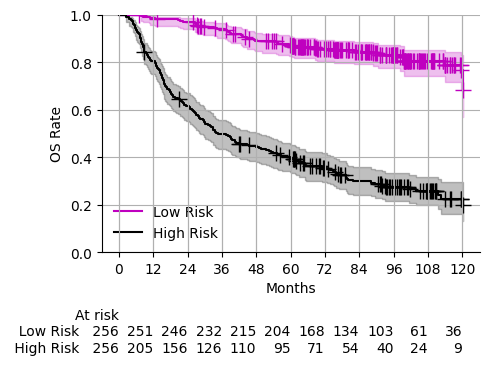

In [128]:
duration = data[['OS']]
duration[duration>3660]=3660
duration /= (365/12)
event = data[['Death']]

score = concordance_index(
                event_times=duration, 
                predicted_scores = -data['OS_risk'], 
                event_observed= event,
            )
print('C-index is', score)

high_risk_ind = np.argwhere(data['OS_risk'].values >= np.median(data['OS_risk']))
low_risk_ind = np.argwhere(data['OS_risk'].values < np.median(data['OS_risk']))

cum_event = event
cum_duration = duration

durations = cum_duration.to_numpy()
events= cum_event.to_numpy()

plt.figure(figsize=(5,4))
ax = plt.subplot(111)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

kmf_low = lifelines.KaplanMeierFitter()
ax = kmf_low.fit(durations[low_risk_ind], event_observed=events[low_risk_ind], label="Low Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='m')

kmf_high = lifelines.KaplanMeierFitter()
ax = kmf_high.fit(durations[high_risk_ind], event_observed=events[high_risk_ind], label="High Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='k') #, linestyle='dashed'
plt.xticks(np.linspace(0,120,11))
plt.grid()
plt.xlabel('Months')
plt.ylabel('OS Rate')
plt.legend(frameon=False)

add_at_risk_counts(kmf_low, kmf_high, ax=ax, rows_to_show=['At risk'])
plt.tight_layout()
plt.ylim([0, 1])
plt.savefig('ViT_OS.png', dpi=300)
plt.grid()
results = logrank_test(durations[high_risk_ind], durations[low_risk_ind], events[high_risk_ind], events[low_risk_ind], alpha=.95)

results.print_summary()

In [129]:
os_temp = data[['OS_risk', 'OS', 'Death']]
os_temp

,OS_risk,OS,Death
0,5.585012,3472,0
1,12.743567,192,1
2,1.793600,3516,0
3,4.623035,3736,0
4,2.179234,3911,0
...,...,...,...
507,2.750700,3133,0
508,1.109411,4339,0
509,10.414908,2126,0
510,8.155293,71,1


In [130]:
from lifelines import CoxPHFitter
cph = CoxPHFitter() # sparse solutions,
cph.fit(os_temp, 'OS', 'Death')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 512 total observations, 282 right-censored observations>
             duration col = 'OS'
                event col = 'Death'
      baseline estimation = breslow
   number of observations = 512
number of events observed = 230
   partial log-likelihood = -1285.30
         time fit was run = 2023-05-05 18:25:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
OS_risk     0.06       1.06       0.00             0.05             0.07                 1.05                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
OS_risk       0.00 14.24 <0.005     150.44
---
Concordance = 0.77
Partial AIC = 2572.60
log-likelihood ratio test = 101.24 on 1 df
-log2(p) of ll-ratio test = 76.70

In [131]:
def CalAUC(data, risk, duration, event, title = "Patient Death Prediction"):
    ### AUC at 1, 3, 5 years for binary prediction (event vs no_event)
    temp = data[(data[duration]>=365)|((data[duration]<365)&(data[event]==1))]
    label = temp[duration]<=365
    print('number of patient: {}, number of event: {}'.format(len(label), len(temp[temp[duration]<=365])))
    fpr, tpr, thresholds = metrics.roc_curve(label.values, temp[risk], pos_label=1)
    auc = metrics.auc(fpr, tpr)

    #create ROC curve
    plt.figure(figsize=(5,4))
    plt.plot(fpr,tpr, label="One-Year Event (AUC = {:.3f})".format(auc))

    #
    temp = data[(data[duration]>=365*3)|((data[duration]<365*3)&(data[event]==1))]
    label = temp[duration]<=365*3
    print('number of patient: {}, number of event: {}'.format(len(label), len(temp[temp[duration]<=365*3])))
    fpr, tpr, thresholds = metrics.roc_curve(label.values, temp[risk], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    #create ROC curve
    plt.plot(fpr,tpr, label="Three-Year Event (AUC = {:.3f})".format(auc))

    #
    temp = data[(data[duration]>=365*5)|((data[duration]<365*5)&(data[event]==1))]
    label = temp[duration]<=365*5
    print('number of patient: {}, number of event: {}'.format(len(label), len(temp[temp[duration]<=365*5])))
    fpr, tpr, thresholds = metrics.roc_curve(label.values, temp[risk], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    #create ROC curve
    plt.plot(fpr,tpr, label="Five-Year Event (AUC = {:.3f})".format(auc))

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    # plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    # plt.show()
    
    plt.savefig(title, dpi=300)

number of patient: 510, number of event: 54
number of patient: 501, number of event: 143
number of patient: 483, number of event: 184


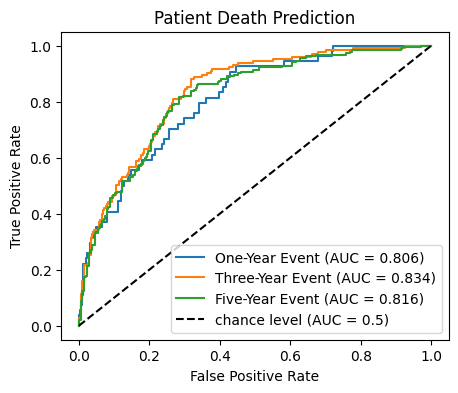

In [132]:
CalAUC(data[['OS_risk', 'OS', 'Death']], 'OS_risk', 'OS', 'Death')

In [150]:
"""
@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [175]:
def CalAUC2(data, risk, duration, event, title = "Patient Death Prediction", alpha = .95):
    ### AUC at 1, 3, 5 years for binary prediction (event vs no_event)
    temp = data[(data[duration]>=365)|((data[duration]<365)&(data[event]==1))]
    label = temp[duration]<=365
    print('number of patient: {}, number of event: {}'.format(len(label), len(temp[temp[duration]<=365])))

    auc, auc_cov = delong_roc_variance(label.values.astype(int), temp[risk])

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)


    #
    temp = data[(data[duration]>=365*3)|((data[duration]<365*3)&(data[event]==1))]
    label = temp[duration]<=365*3
    print('number of patient: {}, number of event: {}'.format(len(label), len(temp[temp[duration]<=365*3])))

    auc, auc_cov = delong_roc_variance(label.values.astype(int), temp[risk])

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)

    #
    temp = data[(data[duration]>=365*5)|((data[duration]<365*5)&(data[event]==1))]
    label = temp[duration]<=365*5
    print('number of patient: {}, number of event: {}'.format(len(label), len(temp[temp[duration]<=365*5])))

    auc, auc_cov = delong_roc_variance(label.values.astype(int), temp[risk])

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)

In [176]:
CalAUC2(data[['OS_risk', 'OS', 'Death']], 'OS_risk', 'OS', 'Death')

number of patient: 510, number of event: 54
AUC: 0.8058398310591293
AUC COV: 0.0008308722645008374
95% AUC CI: [0.74934415 0.86233551]
number of patient: 501, number of event: 143
AUC: 0.834179786693753
AUC COV: 0.0003558055889242227
95% AUC CI: [0.79720936 0.87115021]
number of patient: 483, number of event: 184
AUC: 0.8158899229315107
AUC COV: 0.00038444771318849134
95% AUC CI: [0.77746025 0.8543196 ]


/tmp/ipykernel_954850/2843399697.py:201: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  predictions_sorted_transposed = predictions[np.newaxis, order]
/tmp/ipykernel_954850/2843399697.py:151: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_954850/2843399697.py:152: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy 

In [133]:
def Cal_ConfidenceInterval(data, risk_name, duration_name, event_name, iteration=10000, alpha=0.95):
    stats = list()
    for i in range(iteration):
        data_sample = data.sample(frac=0.632, replace=True)
        stats.append(concordance_index(
                event_times=data_sample[duration_name], 
                predicted_scores = -data_sample[risk_name], 
                event_observed= data_sample[event_name],
            ))
    plt.hist(stats)
    plt.show()
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.3f and %.3f' % (alpha*100, lower, upper))   
    
    return stats

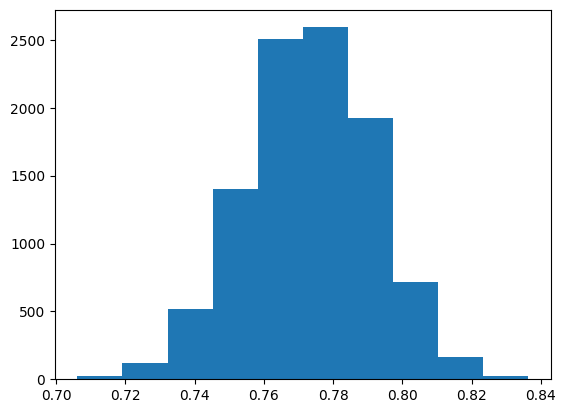

95.0 confidence interval 0.736 and 0.808


In [134]:
scores_OS = Cal_ConfidenceInterval(data[['OS_risk', 'OS', 'Death']], 'OS_risk', 'OS', 'Death')

In [135]:
np.median(scores_OS)

0.7731727149192469

C-index is 0.7550997020398809


/tmp/ipykernel_954850/3892166873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660
/tmp/ipykernel_954850/3892166873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          33.86 <0.005     27.33

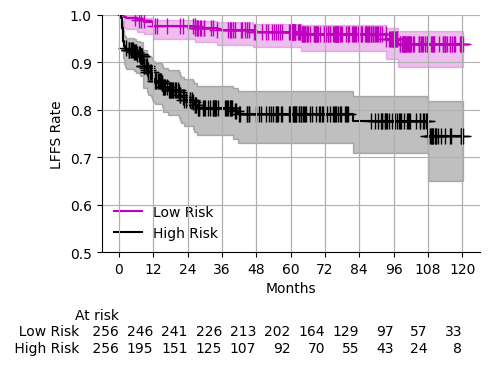

In [136]:
duration = data[['LFFS']]
duration[duration>3660]=3660
duration /= (365/12)
event = data[['LF']]


score = concordance_index(
                event_times=duration, 
                predicted_scores = -data['LFFS_risk'].values, 
                event_observed= event,
            )
print('C-index is', score)

high_risk_ind = np.argwhere(data['LFFS_risk'].values >= np.median(data['LFFS_risk']))
low_risk_ind = np.argwhere(data['LFFS_risk'].values < np.median(data['LFFS_risk']))

cum_event = event
cum_duration = duration

durations = cum_duration.to_numpy()
events= cum_event.to_numpy()

plt.figure(figsize=(5,4))
ax = plt.subplot(111)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

kmf_low = lifelines.KaplanMeierFitter()
ax = kmf_low.fit(durations[low_risk_ind], event_observed=events[low_risk_ind], label="Low Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='m')

kmf_high = lifelines.KaplanMeierFitter()
ax = kmf_high.fit(durations[high_risk_ind], event_observed=events[high_risk_ind], label="High Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='k') #, linestyle='dashed'
plt.xticks(np.linspace(0,120,11))
plt.grid()
plt.xlabel('Months')
plt.ylabel('LFFS Rate')
plt.legend(frameon=False)

add_at_risk_counts(kmf_low, kmf_high, ax=ax, rows_to_show=['At risk'])
plt.tight_layout()
plt.ylim([0.5, 1])
plt.savefig('ViT_LFFS.png', dpi=300)
plt.grid()
results = logrank_test(durations[high_risk_ind], durations[low_risk_ind], events[high_risk_ind], events[low_risk_ind], alpha=.95)

results.print_summary()

number of patient: 479, number of event: 38
number of patient: 404, number of event: 53
number of patient: 350, number of event: 56


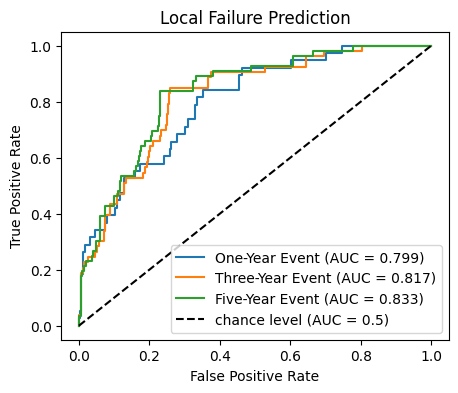

In [137]:
CalAUC(data[['LFFS_risk', 'LFFS', 'LF']], 'LFFS_risk', 'LFFS', 'LF',"Local Failure Prediction")

In [179]:
CalAUC2(data[['LFFS_risk', 'LFFS', 'LF']], 'LFFS_risk', 'LFFS', 'LF',"Local Failure Prediction")

number of patient: 479, number of event: 38
AUC: 0.7985439789951068
AUC COV: 0.0012181515527353271
95% AUC CI: [0.73013726 0.8669507 ]
number of patient: 404, number of event: 53
AUC: 0.8171800247271945
AUC COV: 0.0008383765904483532
95% AUC CI: [0.76042979 0.87393026]
number of patient: 350, number of event: 56
AUC: 0.8332118561710398
AUC COV: 0.0007403151315399097
95% AUC CI: [0.77988372 0.88653999]


/tmp/ipykernel_954850/2843399697.py:201: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  predictions_sorted_transposed = predictions[np.newaxis, order]
/tmp/ipykernel_954850/2843399697.py:151: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_954850/2843399697.py:152: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy 

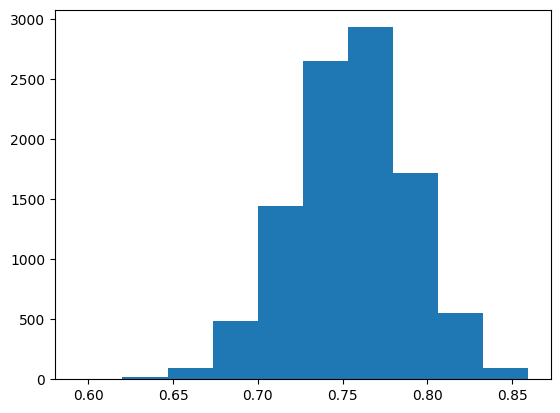

95.0 confidence interval 0.685 and 0.821


0.7555930893354228

In [138]:
score_LF = Cal_ConfidenceInterval(data[['LFFS_risk', 'LFFS', 'LF']], 'LFFS_risk', 'LFFS', 'LF')
np.median(score_LF)

C-index is 0.7604562737642585


/tmp/ipykernel_954850/1987291680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660
/tmp/ipykernel_954850/1987291680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          24.05 <0.005     20.02

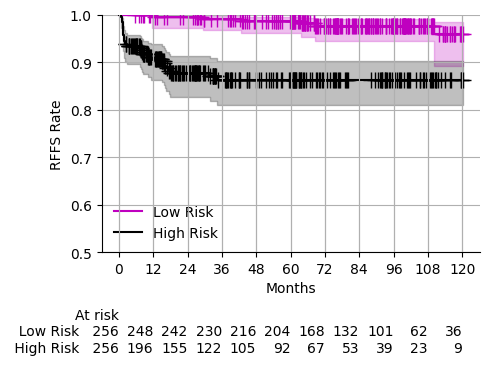

In [139]:
duration = data[['RFFS']]
duration[duration>3660]=3660
duration /= (365/12)
event = data[['RF']]

score = concordance_index(
                event_times=duration, 
                predicted_scores = -data['RFFS_risk'].values, 
                event_observed= event,
            )
print('C-index is', score)

high_risk_ind = np.argwhere(data['RFFS_risk'].values >= np.median(data['RFFS_risk']))
low_risk_ind = np.argwhere(data['RFFS_risk'].values < np.median(data['RFFS_risk']))

cum_event = event
cum_duration = duration

durations = cum_duration.to_numpy()
events= cum_event.to_numpy()

plt.figure(figsize=(5,4))
ax = plt.subplot(111)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

kmf_low = lifelines.KaplanMeierFitter()
ax = kmf_low.fit(durations[low_risk_ind], event_observed=events[low_risk_ind], label="Low Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='m')

kmf_high = lifelines.KaplanMeierFitter()
ax = kmf_high.fit(durations[high_risk_ind], event_observed=events[high_risk_ind], label="High Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='k') #, linestyle='dashed'
plt.xticks(np.linspace(0,120,11))
plt.grid()
plt.xlabel('Months')
plt.ylabel('RFFS Rate')
plt.legend(frameon=False)

add_at_risk_counts(kmf_low, kmf_high, ax=ax, rows_to_show=['At risk'])
plt.tight_layout()
plt.ylim([0.5, 1])
plt.savefig('ViT_RFFS.png', dpi=300)
plt.grid()
results = logrank_test(durations[high_risk_ind], durations[low_risk_ind], events[high_risk_ind], events[low_risk_ind], alpha=.95)

results.print_summary()

number of patient: 468, number of event: 24
number of patient: 385, number of event: 33
number of patient: 330, number of event: 34


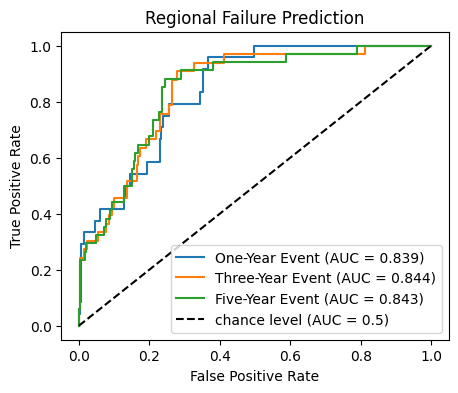

In [140]:
CalAUC(data[['RFFS_risk', 'RFFS', 'RF']], 'RFFS_risk', 'RFFS', 'RF',"Regional Failure Prediction")

In [178]:
CalAUC2(data[['RFFS_risk', 'RFFS', 'RF']], 'RFFS_risk', 'RFFS', 'RF',"Regional Failure Prediction")

number of patient: 468, number of event: 24
AUC: 0.8392454954954955
AUC COV: 0.0010493317009608013
95% AUC CI: [0.77575562 0.90273537]
number of patient: 385, number of event: 33
AUC: 0.8438360881542698
AUC COV: 0.0009606052407976039
95% AUC CI: [0.78308969 0.90458249]
number of patient: 330, number of event: 34
AUC: 0.8433028616852146
AUC COV: 0.0010233177197878284
95% AUC CI: [0.78060491 0.90600081]


/tmp/ipykernel_954850/2843399697.py:201: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  predictions_sorted_transposed = predictions[np.newaxis, order]
/tmp/ipykernel_954850/2843399697.py:151: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_954850/2843399697.py:152: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy 

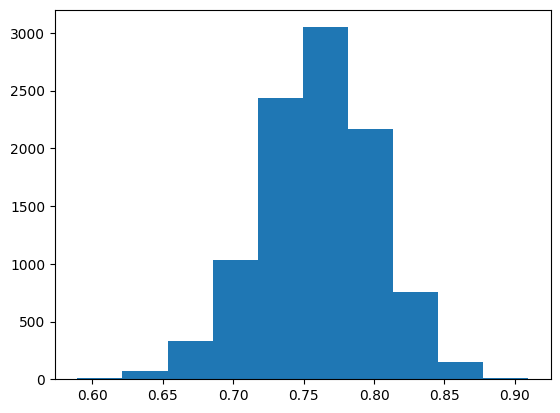

95.0 confidence interval 0.675 and 0.836


In [141]:
score_RF = Cal_ConfidenceInterval(data[['RFFS_risk', 'RFFS', 'RF']], 'RFFS_risk', 'RFFS', 'RF')

In [142]:
np.median(score_RF)

0.7613515092253555

C-index is 0.7708984312083239


/tmp/ipykernel_954850/2000086194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660
/tmp/ipykernel_954850/2000086194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration[duration>3660]=3660


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          49.58 <0.005     38.93

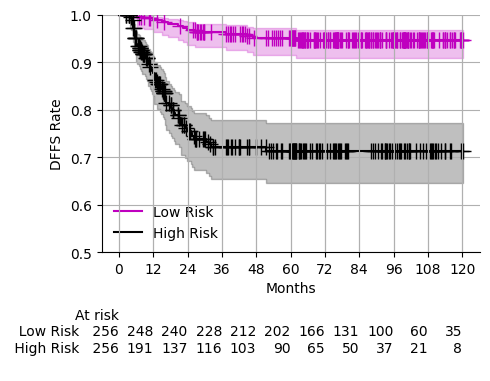

In [143]:
duration = data[['DFFS']]
duration[duration>3660]=3660
duration /= (365/12)
event = data[['DF']]

score = concordance_index(
                event_times=duration, 
                predicted_scores = -data['DFFS_risk'].values, 
                event_observed= event,
            )
print('C-index is', score)

high_risk_ind = np.argwhere(data['DFFS_risk'].values >= np.median(data['DFFS_risk']))
low_risk_ind = np.argwhere(data['DFFS_risk'].values < np.median(data['DFFS_risk']))

cum_event = event
cum_duration = duration

durations = cum_duration.to_numpy()
events= cum_event.to_numpy()

plt.figure(figsize=(5,4))
ax = plt.subplot(111)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

kmf_low = lifelines.KaplanMeierFitter()
ax = kmf_low.fit(durations[low_risk_ind], event_observed=events[low_risk_ind], label="Low Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='m')

kmf_high = lifelines.KaplanMeierFitter()
ax = kmf_high.fit(durations[high_risk_ind], event_observed=events[high_risk_ind], label="High Risk").plot_survival_function(show_censors=True,ci_show=True, ax=ax,color='k') #, linestyle='dashed'
plt.xticks(np.linspace(0,120,11))
plt.grid()
plt.xlabel('Months')
plt.ylabel('DFFS Rate')
plt.legend(frameon=False)

add_at_risk_counts(kmf_low, kmf_high, ax=ax, rows_to_show=['At risk'])
plt.tight_layout()
plt.ylim([0.5, 1])
plt.savefig('ViT_DFS.png', dpi=300)
plt.grid()
results = logrank_test(durations[high_risk_ind], durations[low_risk_ind], events[high_risk_ind], events[low_risk_ind], alpha=.95)

results.print_summary()

number of patient: 471, number of event: 32
number of patient: 412, number of event: 68
number of patient: 364, number of event: 72


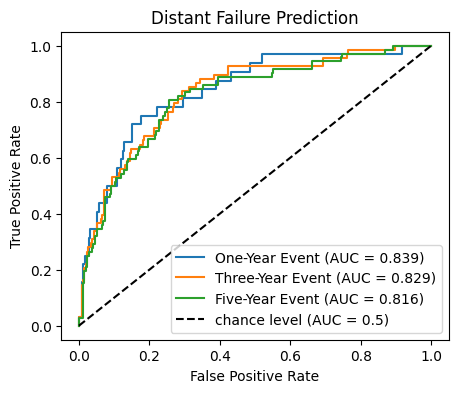

In [144]:
CalAUC(data[['DFFS_risk', 'DFFS', 'DF']], 'DFFS_risk', 'DFFS', 'DF',"Distant Failure Prediction")

In [177]:
CalAUC2(data[['DFFS_risk', 'DFFS', 'DF']], 'DFFS_risk', 'DFFS', 'DF',"Distant Failure Prediction")

number of patient: 471, number of event: 32
AUC: 0.8386958997722096
AUC COV: 0.0013820673302854137
95% AUC CI: [0.76583195 0.91155985]
number of patient: 412, number of event: 68
AUC: 0.8285738714090287
AUC COV: 0.0007385551566390658
95% AUC CI: [0.77530916 0.88183858]
number of patient: 364, number of event: 72
AUC: 0.8164954337899544
AUC COV: 0.0008039738323622452
95% AUC CI: [0.76092177 0.8720691 ]


/tmp/ipykernel_954850/2843399697.py:201: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  predictions_sorted_transposed = predictions[np.newaxis, order]
/tmp/ipykernel_954850/2843399697.py:151: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_954850/2843399697.py:152: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy 

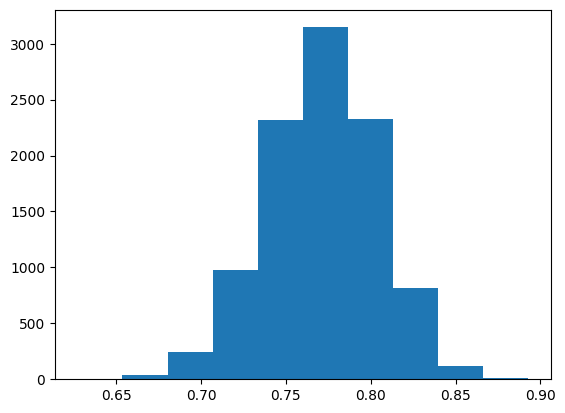

95.0 confidence interval 0.705 and 0.832


In [145]:
score_DF = Cal_ConfidenceInterval(data[['DFFS_risk', 'DFFS', 'DF']], 'DFFS_risk', 'DFFS', 'DF')

In [146]:
np.median(score_DF)

0.771753025727985

In [147]:
from scipy.stats import ttest_ind
ttest_ind(scores_OS, score_LF)

Ttest_indResult(statistic=46.9150184566502, pvalue=0.0)

In [148]:
ttest_ind(scores_OS, score_RF)

Ttest_indResult(statistic=28.920797761369393, pvalue=3.3108938200009314e-180)

In [149]:
ttest_ind(scores_OS, score_DF)

Ttest_indResult(statistic=5.266159600751333, pvalue=1.4074790420101908e-07)